In [1]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pprint as pp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math

from regression import PolynomialLibrary, TrigLibrary
import sindy_helper
from dynamicalsystems import TrainDataset
from fullSINDyAutoencoder import FullSINDyAutoencoder

In [2]:
print("Still debuging FullSINDyAutoencoder.get_dX I set the reg['dX'] = 0 in the loss args")

Still debuging FullSINDyAutoencoder.get_dX I set the reg['dX'] = 0 in the loss args


In [3]:
#load data
dataset = TrainDataset()
total_samples = len(dataset)

hyper_pers = {
    'learn_rate' : 1e-2,
    'batch_size' : 64,
    'num_epochs' : 100,
    'num_features' : 2,
    'loss_reg' : {
        'X' : 1,
        'SINDy' : 1,
        'dX' : 0, #dX is regularization is 0 because dX_pred = None
        'Xi' : 0
    },
    'total_samples' : total_samples,
    
}

dataloader = DataLoader(dataset=dataset, batch_size=hyper_pers['batch_size'], shuffle=True, num_workers=2)
dataiter = iter(dataloader)



def load_model(state_dict_PATH=None):
    model = FullSINDyAutoencoder(hyper_pers['batch_size'], hyper_pers['num_features'])
    if state_dict_PATH is not None:
        if state_dict_PATH == ':latest':
            from os import listdir
            from os.path import isfile, join
            onlyfiles = [f for f in listdir('models/') if isfile(join('models/', f))]
            onlyfiles.sort(reverse=True)
            state_dict_PATH = 'models/' + onlyfiles[0]
        model.load_state_dict(torch.load(state_dict_PATH))
        print("Using Model: " + state_dict_PATH)
    return model

model = load_model(state_dict_PATH =':latest')
optimizer = torch.optim.Adam(model.parameters(),lr=hyper_pers['learn_rate'])

Using Model: models/2022-04-18 01:07:43.683031


In [4]:
#model.SINDy_layer[0].weight

In [5]:
#print(list(model.parameters()))

In [9]:
nn.init.normal_(model.SINDy_layer[0].weight)

Parameter containing:
tensor([[ 0.4111,  1.5698, -0.3577,  1.1791,  0.4951, -0.9307,  0.2114],
        [ 0.2612,  0.0051,  0.1593,  0.4423,  0.1521, -0.5259,  3.0506]],
       requires_grad=True)

In [7]:
def save_model(model):
    import datetime
    timestamp = str(datetime.datetime.now())
    PATH = 'models/' + timestamp
    torch.save(model.state_dict(),PATH)
    print("Saved model to : " + str(PATH))
def train(hyper_pers,verbose=True):
    losses = []
    total_samples = len(dataset)
    n_iter = math.ceil(total_samples / hyper_pers['batch_size'])
    for epoch in range(hyper_pers['num_epochs']):
        #print("Epoch " + str(epoch) + '\t' + str(hyper_pers['loss_reg']))
        if verbose:
            print("w \t" + str(model.SINDy_layer[0].weight))
        l = []
        for i, (X, dX) in enumerate(dataloader):
            if X.shape[0] == hyper_pers['batch_size']:
                res = model.forward(X,dX)
                loss = model.loss(args=res,reg=hyper_pers['loss_reg'])   
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            l.append(loss.item())
        losses.append(np.mean(np.array(l)))
        #print(loss.item())
        if epoch % 10 == 0:
            model.show()
        if epoch % hyper_pers['save_freq'] == hyper_pers['save_freq'] - 1:
            save_model(model)
        if epoch % 20 == 0:
            X = dataset.X
            Z = model.encoder(X).detach().numpy()
            [U,S,Vt] = np.linalg.svd(np.dot(Z.T,Z))
            A=np.dot(U,Z.T).T
            plt.plot(A[:,1],A[:,0])
            plt.show()
        
    plt.plot(np.log(np.array(losses)))
    plt.title("log loss")
    return losses


(z1)' = 0.0 1 + -0.002 x1 + 0.0 x2 + 0.0 sin(x1) + 0.0 sin(x2) + -0.001 cos(x1) + -0.0 cos(x2)
(z2)' = -0.0 1 + -0.001 x1 + 0.001 x2 + 0.0 sin(x1) + 0.0 sin(x2) + -0.0 cos(x1) + -0.001 cos(x2)


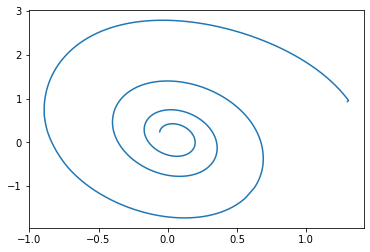

(z1)' = -0.001 1 + 0.001 x1 + -0.001 x2 + -0.001 sin(x1) + -0.002 sin(x2) + -0.002 cos(x1) + -0.001 cos(x2)
(z2)' = -0.001 1 + 0.001 x1 + -0.001 x2 + -0.001 sin(x1) + -0.001 sin(x2) + -0.001 cos(x1) + -0.001 cos(x2)
(z1)' = 0.002 1 + -0.001 x1 + 0.001 x2 + 0.002 sin(x1) + 0.001 sin(x2) + 0.001 cos(x1) + 0.003 cos(x2)
(z2)' = -0.0 1 + -0.001 x1 + 0.003 x2 + -0.001 sin(x1) + -0.001 sin(x2) + -0.0 cos(x1) + 0.003 cos(x2)


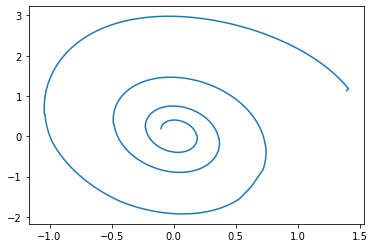

[0.30261234706564316,
 0.33517400573962813,
 0.25868562651667626,
 0.24411074940566044,
 0.24352720892353422,
 0.2766612369543428,
 0.2699265602952356,
 0.25735363592008115,
 0.22879904575028998,
 0.24532029673362235,
 0.26522839733749437,
 0.2635853750880357,
 0.2730572137293542,
 0.2540225597323885,
 0.24770582894420928,
 0.2511767007552894,
 0.22981014510818348,
 0.2784151864849078,
 0.27091463873530647,
 0.2540845777483503,
 0.3086427651867745,
 0.24664049092561577,
 0.23991632921870348,
 0.26198974375132544,
 0.2498418954052743,
 0.2458654988058813,
 0.2741255811919832,
 0.2716738957982914,
 0.2575099691748619,
 0.2530040316710806]

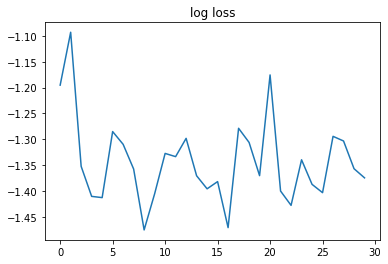

In [11]:
train(hyper_pers = {
    'learn_rate' : 1e-3,
    'batch_size' : 64,
    'num_epochs' : 30,
    'save_freq' : 200,
    'num_features' : 2,
    'loss_reg' : {
        'X' : 1,
        'SINDy' : 1,
        'dX' : 0, #dX is regularization is 0 because dX_pred = None
        'Xi' : 0
    },
    'total_samples' : total_samples,
    
},verbose=False)

In [ ]:
save_model(model)

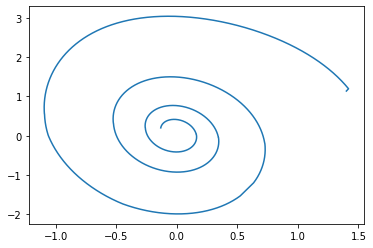

In [12]:
X = dataset.X
Z = model.encoder(X).detach().numpy()
[U,S,Vt] = np.linalg.svd(np.dot(Z.T,Z))
A=np.dot(U,Z.T).T
plt.plot(A[:,1],A[:,0])
plt.show()

In [13]:
np.save('Z.npy',A)

In [ ]:
model.get_dZ(dataset.X,dataset.dX)